## Import required packages

In [1]:
import os
import glob
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


## Load the Data

In [2]:
df = pd.read_csv('store_products.csv')
print(df.shape)
print(df.head())

(120, 2)
     txn           category
0  txn 1       Tomato Juice
1  txn 1             Turkey
2  txn 1      Mineral Water
3  txn 1       Green Grapes
4  txn 1  Antioxydant Juice


## Data Preprocessing

In [3]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
basket = df.groupby(['txn','category']).size().reset_index(name='count')
basket = (basket.groupby(['txn', 'category'])['count']
          .sum().unstack().reset_index().fillna(0)
          .set_index('txn'))
basket_sets = basket.applymap(encode_units)
basket_sets.head()

category,Almonds,Antioxydant Juice,Avocado,Burgers,Chutney,Cottage Cheese,Energy Drink,French Fries,Frozen Smoothie,Frozen Vegetables,...,Salmon,Shrimp,Soup,Spinach,Tomato Juice,Turkey,Vegetables Mix,Whole Weat Flour,Whole Wheat Pasta,Yams
txn,,,,,,,,,,,,,,,,,,,,,
txn 1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
txn 10,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
txn 11,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
txn 12,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
txn 13,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


## Association rules generation

In [4]:
frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values('confidence', ascending = False, inplace = True)

rules = rules.reset_index(drop=True)
rules.shape

(78, 9)

In [5]:
for index, row in rules.iterrows():  
    a = [x for x in rules['antecedents'][index]]
    c = [x for x in rules['consequents'][index]]
    rules.loc[index, 'antecedents_formatted'] = str(a)
    rules.loc[index, 'consequents_formatted'] = str(c)
    
rules=rules[['antecedents_formatted', 'consequents_formatted', 'antecedent support',
       'consequent support', 'support', 'confidence', 'lift', 'leverage',
       'conviction']]
rules.columns=['antecedents', 'consequents', 'antecedent support',
       'consequent support', 'support', 'confidence', 'lift', 'leverage',
       'conviction']
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"['Vegetables Mix', 'Low Fat Yogurt']",['Yams'],0.066667,0.133333,0.066667,1.00,7.500000,0.057778,inf
1,"['Yams', 'Vegetables Mix']",['Low Fat Yogurt'],0.066667,0.233333,0.066667,1.00,4.285714,0.051111,inf
2,"['Honey', 'Shrimp']",['Mineral Water'],0.066667,0.266667,0.066667,1.00,3.750000,0.048889,inf
3,"['Mineral Water', 'Honey']",['Shrimp'],0.066667,0.233333,0.066667,1.00,4.285714,0.051111,inf
4,['Yams'],['Low Fat Yogurt'],0.133333,0.233333,0.100000,0.75,3.214286,0.068889,3.066667


## Results to CSV

In [6]:
rules.to_csv("results.csv", index = False)

## Other Visualisation

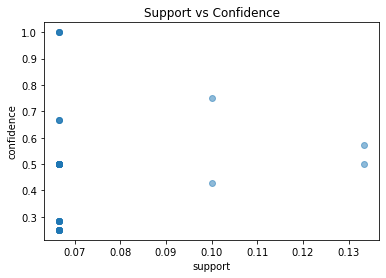

In [7]:
import matplotlib.pyplot as plt
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

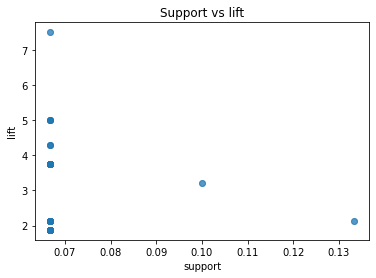

In [8]:
plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs lift')
plt.show()

In [9]:
import numpy as np
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'],fit_fn(rules['lift']))